# Urban Sound Classification: Deep Learning Approaches for Audio Recognition
## Machine Learning II
#### Work assembled by Beatriz Pereira, Carolina Leite, Lara Gonçalves

### Table of contents <a name="contents"></a>
1. [Introduction](#introduction)
2. [Data Understanding](#data-understanding)
3. [Data Reading](#data-reading)
    - 3.1. [Feature Extraction](#feature-extraction)
    - 3.2. [Data Cleaning](#data-cleaning)
      
      - 3.2.1. [Reading](#reading)
      
      - 3.2.2. [Cleaning](#cleaning)
     
4. [Modeling](#modeling)

## 1. Introduction <a name="introduction"></a>
[[go back to the top]](#contents)

The objective of this project is to develop **deep learning classifiers** for urban sound data. In this assignment, we will implement two of the three classifiers provided by the professor, as outlined in the [[PDF]](AC2_Project_20252026.pdf). 

The classifiers are:

• A classifier based on a multilayer perceptron (MLP)

• A classifier based on a convolutional neural network (CNN)

• A classifier based on a recurrent neural network (RNN)

And for each of the chosen classifier, the implementation will need to consider the following steps:
1. Data pre-processing and preparation
2. Model architecture definition
3. Training strategies
4. Performance evaluation

#### Imports

In [24]:
!pip install librosa

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import librosa
import os
import numpy as np
import soundfile as sf
from sklearn.preprocessing import MinMaxScaler
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd 
import librosa.display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## 2. Data Understanding <a name="data-understanding"></a>
[[go back to the top]](#contents)

The dataset consists of 8,732 labeled sound excerpts, each lasting up to 4 seconds, categorized into 10 distinct classes:
- air_conditioner [0] 
- car_horn [1] 
- children_playing [2] 
- dog_bark [3] 
- drilling [4] 
- enginge_idling [5] 
- gun_shot [6] 
- jackhammer [7] 
- siren [8] 
- street_music [9] 

The sound classes in the UrbanSound and UrbanSound8K datasets are derived from the UrbanSound taxonomy, as presented on the https://urbansounddataset.weebly.com/taxonomy.html

Below is an image showcasing the taxonomy structure from the referenced site:

![urban_sound_taxonomy](./images/urban_sound_taxonomy.png)

All audio excerpts are derived from field recordings uploaded to http://www.freesound.org/

The dataset comprises 8,732 urban sound audio files in WAV format. The sampling rate, bit depth, and number of channels correspond to those of the original files uploaded to Freesound, which may vary across different recordings.

In addition to the audio excerpts, a CSV file containing metadata for each excerpt is also included.

This is a short explanation of the csv:

| Name of the Column | Brief Explanation                                                                                       |
|--------------------|--------------------------------------------------------------------------------------------------------|
| slice_file_name    | The name of the audio file, formatted as [fsID]-[classID]-[occurrenceID]-[sliceID].wav.              |
| fsID               | The Freesound ID of the recording from which this excerpt (slice) is taken.                           |
| start              | The start time of the slice in the original Freesound recording.                                      |
| end                | The end time of the slice in the original Freesound recording.                                        |
| salience           | A subjective salience rating of the sound (1 = foreground, 2 = background).                           |
| fold               | The fold number (1-10) to which this file has been allocated.                                         |
| classID            | A numeric identifier of the sound class (0-9) as listed above.                                        |
| [occurrenceID]     | A numeric identifier to distinguish different occurrences of the sound within the original recording. |
| [sliceID]          | A numeric identifier to distinguish different slices taken from the same occurrence.                 |


**To avoid common pitfalls**:
-  Don't reshuffle the data! Use the predefined 10 folds and perform 10-fold (not 5-fold) cross validation
-  Don't evaluate just on one split! Use 10-fold (not 5-fold) cross validation and average the scores

## 3. Data Reading <a name="data-reading"></a>
[[go back to the top]](#contents)


After carefully analyzing the three available classifiers, we decided to implement CNN and RNN for this project. Our decision was based on several important considerations, which we have outlined in detail in the following [[Summary]](Research/Summary.md).


### Librosa vs Scipy.io

**Librosa:** is a library specialized in audio analysis and manipulation for machine learning and digital signal processing. It provides a wide range of tools aimed at feature extraction and audio representations.

- Pros:
    - Supports various audio formats (.wav, .mp3, etc.).
    - Advanced feature extraction: Mel Spectrograms, MFCCs, Chromagrams.
    - Easy audio manipulation (resampling, padding, normalization).
    - Integration with visualizations (spectrograms, MFCCs).

- Cons:
    - Slower for simple tasks (loading/saving audio).
    - Steeper learning curve for beginners.
    - Depends on external libraries (audioread, ffmpeg).

**Scipy.io:** is part of the SciPy library and is a simple and efficient tool for reading and writing .wav files. It is useful for basic audio manipulation tasks.

- Pros:
    - Simple, fast, and efficient for loading/saving .wav files.
    - Direct integration with NumPy for basic manipulation.

- Cons:
    - Limited to .wav files.
    - Does not support advanced feature degradation.
    - Does not offer resampling, padding, or integrated views.

Let's briefly analyze the differences between librosa and scipy.io.

In [2]:
import librosa
import scipy.io.wavfile as wav

In [3]:
filename = r"UrbanSound8K/audio/fold1/7061-6-0-0.wav"

In [4]:
librosa_audio, librosa_sample_rate = librosa.load(filename)
scipy_sample_rate, scipy_audio = wav.read(filename)

c:\ProgramData\anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [5]:
print("Librosa sample wave rate:", librosa_sample_rate)
print("Scipy sample wave rate : " , scipy_sample_rate )

Librosa sample wave rate: 22050
Scipy sample wave rate :  44100


In [6]:
print("Librosa audio signal " , librosa_audio)
print("Librosa audio data type:", librosa_audio.dtype)
print()
print("Scipy audio signal" , scipy_audio)
print("Scipy audio data type:", scipy_audio.dtype)

Librosa audio signal  [-7.4505806e-09  2.9802322e-08  4.8428774e-08 ...  1.0127544e-05
  2.3271263e-05  7.0009992e-06]
Librosa audio data type: float32

Scipy audio signal [[0 0]
 [0 0]
 [0 0]
 ...
 [1 0]
 [1 1]
 [0 0]]
Scipy audio data type: int16


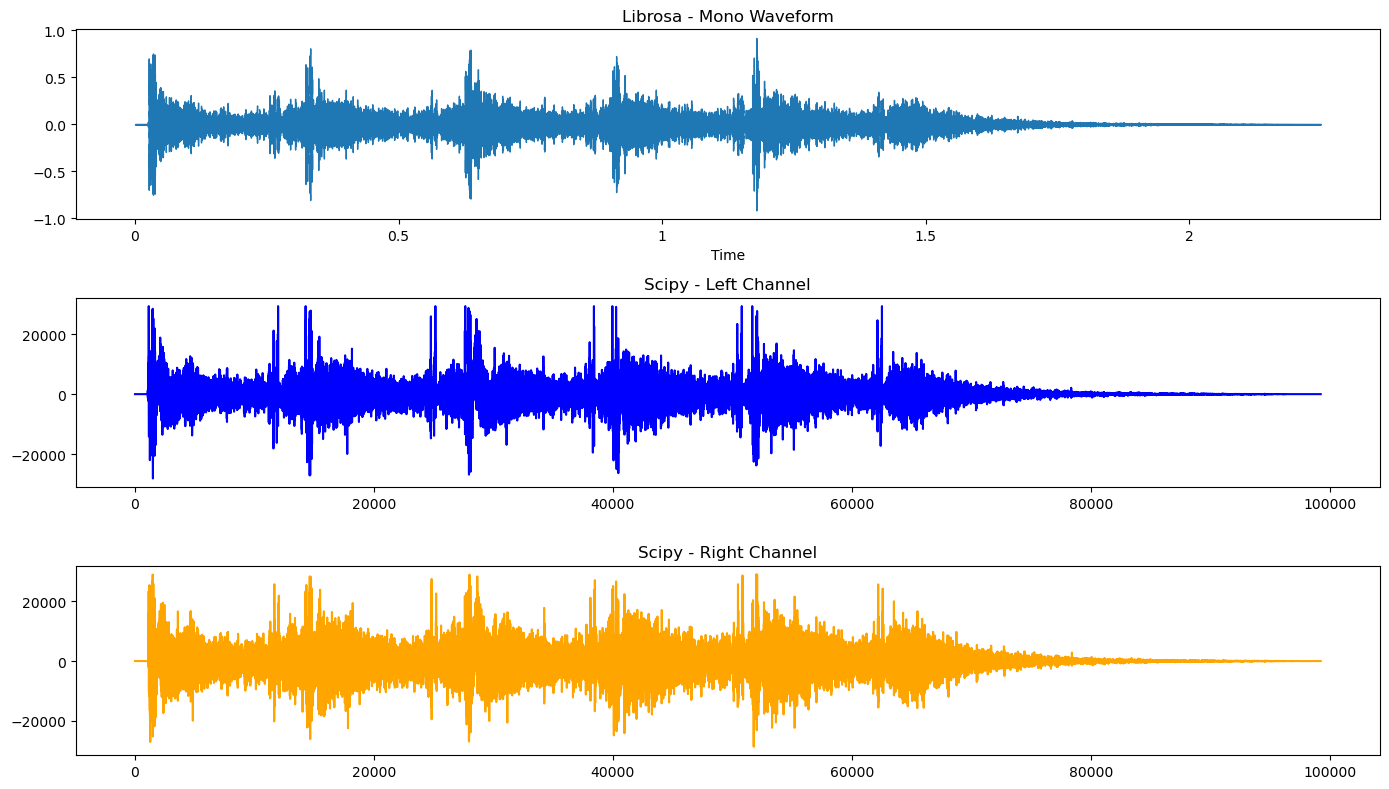

In [7]:
plt.figure(figsize=(14, 8))  # Ajuste o tamanho da figura para mais altura

# Plot librosa mono waveform
plt.subplot(3, 1, 1)
librosa.display.waveshow(librosa_audio, sr=librosa_sample_rate)
plt.title("Librosa - Mono Waveform")

# Plot scipy stereo waveform (each channel separately if stereo)
# Plot left and right channels in separate subplots
plt.subplot(3, 1, 2)
if scipy_audio.ndim > 1:  # Stereo
    plt.plot(scipy_audio[:, 0], label="Left Channel", color='blue')
    plt.title("Scipy - Left Channel")

    plt.subplot(3, 1, 3)
    plt.plot(scipy_audio[:, 1], label="Right Channel", color='orange')
    plt.title("Scipy - Right Channel")
else:  # Mono
    plt.plot(scipy_audio)
    plt.title("Scipy - Mono Waveform")

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()

Taking into account all the pros and cons previously mentioned, we decided that for this work **we will use librosa**, as it offers more advantages for this type of project. Furthermore, it allows, by default, converting all audio to a sampling rate of 22050 Hz (normally used in audio learning and processing models), converting audio into a single signal (mono sound), and also normalizing audio, unlike scipy, which converts audio into arrays.

In [8]:
path_csv = 'UrbanSound8K/metadata/UrbanSound8K.csv'

df = pd.read_csv(path_csv)

df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


##### Check if there's any missing values

In [9]:
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64


As we can see, the dataset **does not contain any null values**, which is great considering that this means there is no missing data, and therefore it is possible to know the correct classification of each audio file.

##### Check if there's any duplicate values

In [10]:
duplicates = df.duplicated()
print(f"Duplicates values: {duplicates.sum()}")

Duplicates values: 0


There are also **no duplicate values**, meaning that each audio file in the dataset, even if it comes from the same original FreeSound audio, is not identical to any other, as it corresponds to different slices within the audio.

##### Data Consistency

Although there appear to be no problems with the data, according to the audio metadata, we need to confirm if, for any reason, there is a file listed in the metadata that does not appear in the audio directory, or if there is any audio that does not appear in the metadata.

In [11]:
audios_dir = r"UrbanSound8K\audio"

Let's start by testing if all the audio files described in the metadata are located in the correct folders:

In [12]:
# Initialize list of missing files
missing_files = []

for index, row in df.iterrows():
    # Build the expected file path
    fold = row['fold']
    folder_name = "fold" + str(fold)
    file_name = row['slice_file_name']
    file_path = os.path.join(audios_dir, folder_name, file_name)
    
    # Check if file exists
    if not os.path.isfile(file_path):
        missing_files.append(file_path)

# Show missing files
if missing_files:
    print(f"Missing files ({len(missing_files)}):")
    for file in missing_files:
        print(file)
else:
    print("All files are present.")

All files are present.


Now, let's check if there are any extra files in the different folds:

In [41]:
# Initialize list of extra files
extra_files = []

for fold in range(1, 11):  # Folders 1 to 10
    folder_name = "folder" + str(fold)
    folder_path = os.path.join(audios_dir, folder_name)
    if os.path.exists(folder_path):
        # List all files in folder
        files_in_folder = os.listdir(folder_path)
        # Filter only audio files
        audio_files = [f for f in files_in_folder if f.endswith('.wav')]
        
        # Compare with files listed in CSV
        expected_files = df[df['fold'] == fold]['slice_file_name'].tolist()
        for audio_file in audio_files:
            if audio_file not in expected_files:
                extra_files.append(os.path.join(folder_path, audio_file))

# Show extra files
if extra_files:
    print(f"Extra files ({len(extra_files)}):")
    for file in extra_files:
        print(file)
else:
    print("No extra files found.")


No extra files found.


As we can see, there are no inconsistencies between the data described in the metadata and the audio files we have. We can therefore proceed to a more detailed analysis of the data.

c:\ProgramData\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


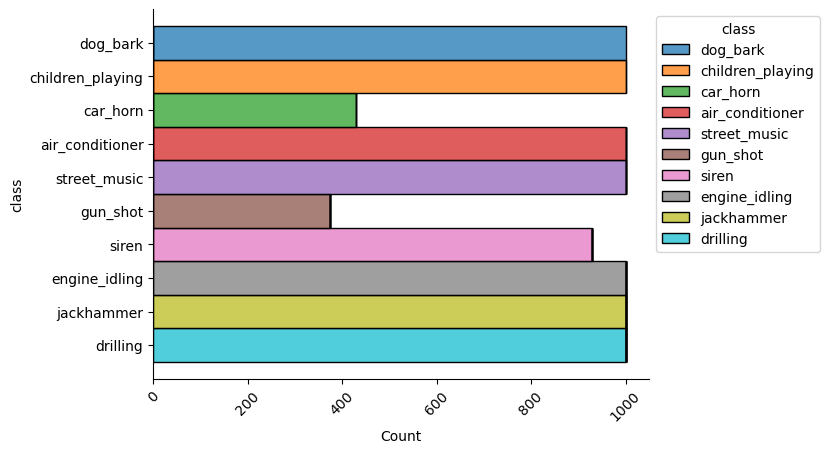

In [13]:
ax = sns.histplot(y='class',data = df, hue="class", multiple="stack")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
sns.despine()
plt.show()

In [14]:
class_dict = df['class'].value_counts(normalize=True)

In [15]:
class_dict

class
dog_bark            0.114521
children_playing    0.114521
air_conditioner     0.114521
street_music        0.114521
engine_idling       0.114521
jackhammer          0.114521
drilling            0.114521
siren               0.106390
car_horn            0.049130
gun_shot            0.042831
Name: proportion, dtype: float64

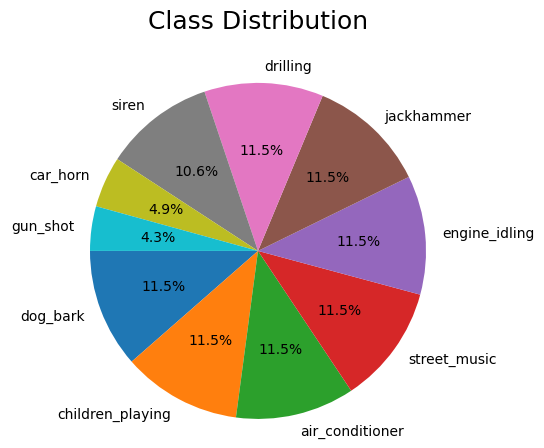

In [16]:
classes = class_dict.index
values = class_dict.values

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08, fontsize=18)
ax.pie(values, labels=classes, autopct='%1.1f%%', shadow=False, startangle=180)
ax.axis('equal')
plt.show(block=False)

Although the **'car_horn'** and **'gun_shot'** classes have fewer entries, and therefore fewer audio files of those types, the dataset appears to be minimally balanced, so no changes are necessary.

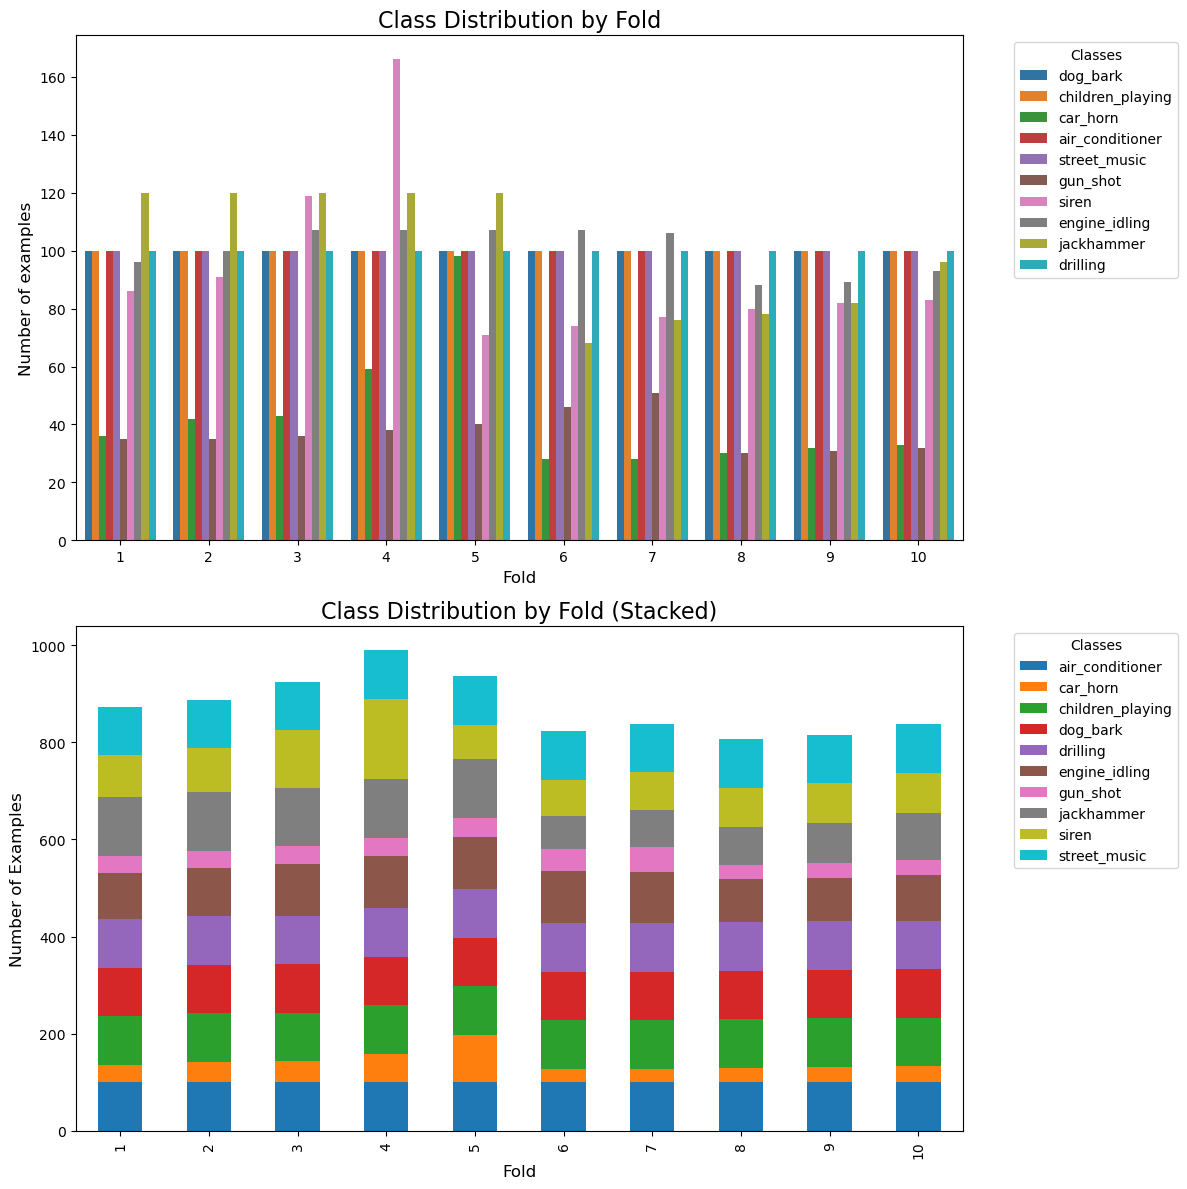

In [17]:
# Create the figure and subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Color palette
palette = sns.color_palette("tab10")

# First graphic: Countplot
sns.countplot(
    data=df, 
    x='fold', 
    hue='class', 
    palette=palette, 
    ax=axes[0]
)
axes[0].set_title('Class Distribution by Fold', fontsize=16)
axes[0].set_xlabel('Fold', fontsize=12)
axes[0].set_ylabel('Number of examples', fontsize=12)
axes[0].legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

# Count number of examples of each class by fold
class_fold_distribution = df.groupby(['fold', 'class']).size().unstack(fill_value=0)

# Second graphics: Stacked bars
class_fold_distribution.plot(
    kind='bar', 
    stacked=True, 
    colormap='tab10',
    ax=axes[1]
)
axes[1].set_title('Class Distribution by Fold (Stacked)', fontsize=16)
axes[1].set_xlabel('Fold', fontsize=12)
axes[1].set_ylabel('Number of Examples', fontsize=12)
axes[1].legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [18]:
appended = []
for i in range(1,11):
    appended.append(df[df.fold == i]['class'].value_counts())
    
class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

class,index,jackhammer,dog_bark,children_playing,street_music,air_conditioner,drilling,engine_idling,siren,car_horn,gun_shot
0,fold1,120,100,100,100,100,100,96,86,36,35
1,fold2,120,100,100,100,100,100,100,91,42,35
2,fold3,120,100,100,100,100,100,107,119,43,36
3,fold4,120,100,100,100,100,100,107,166,59,38
4,fold5,120,100,100,100,100,100,107,71,98,40
5,fold6,68,100,100,100,100,100,107,74,28,46
6,fold7,76,100,100,100,100,100,106,77,28,51
7,fold8,78,100,100,100,100,100,88,80,30,30
8,fold9,82,100,100,100,100,100,89,82,32,31
9,fold10,96,100,100,100,100,100,93,83,33,32


Although some classes have fewer entries than others, we can see that by fold the classes seem to be fairly evenly distributed, with approximately the same number of entries per class in each fold.

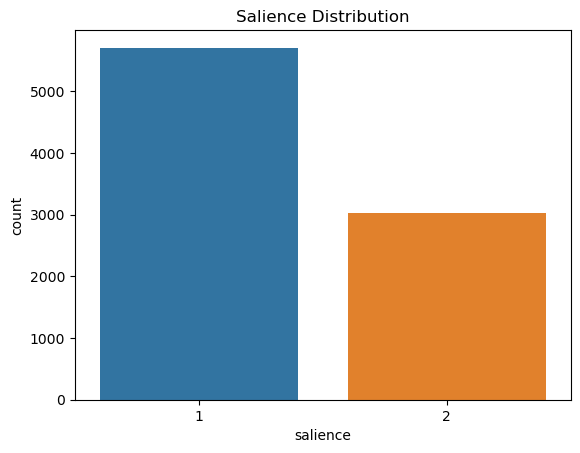

In [19]:
sns.countplot(data = df, x = 'salience')
plt.title('Salience Distribution')
plt.show()

We concluded that most of the audio files are classified as having been obtained from 'foreground' sources.

##### Visualization of a Sound Wave

In [20]:
filename = r"UrbanSound8K/audio/fold1/7383-3-0-0.wav"
librosa_audio, librosa_sample_rate = librosa.load(filename)

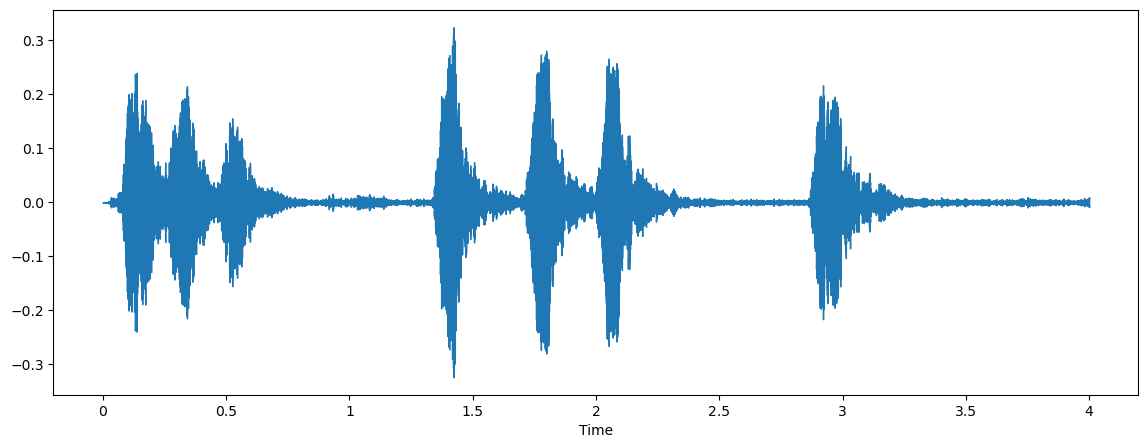

In [21]:
plt.figure(figsize=(14,5))
librosa_audio ,librosa_sample_rate=librosa.load(filename)
librosa.display.waveshow(librosa_audio,sr=librosa_sample_rate)
ipd.Audio(filename)

##### Audio Duration

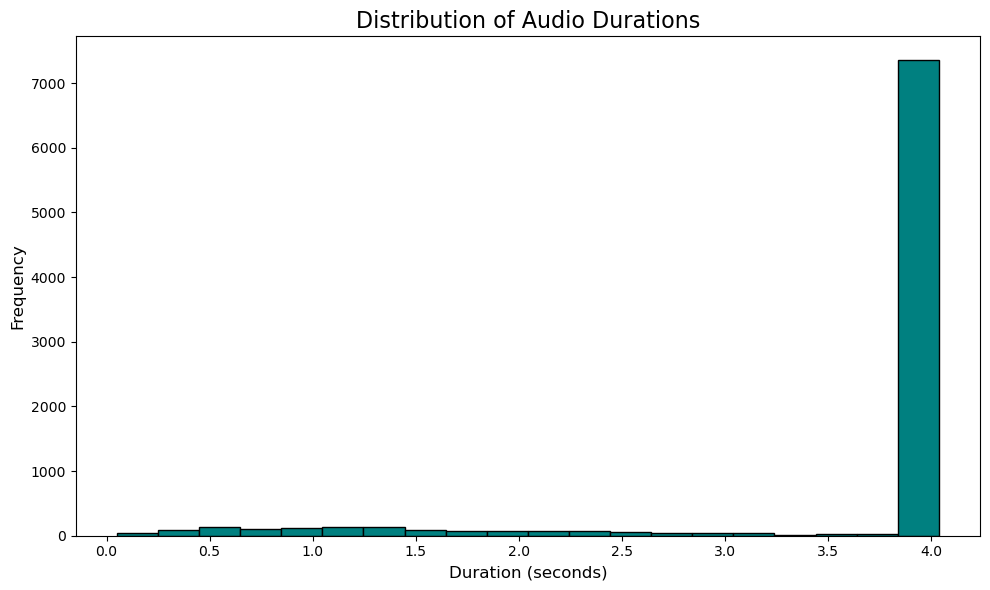

In [22]:
# List for storing durations
durations = []

# Process each audio
for index, row in df.iterrows():
    fold = row['fold']
    fold_name = "fold" + str(fold)
    file_name = row['slice_file_name']
    file_path = os.path.join(audios_dir, fold_name, file_name)
    
    if os.path.isfile(file_path):
        # Load audio
        y, sr = librosa.load(file_path, sr=None)  # sr=None para manter a taxa original
        # Get original duration
        durations.append(librosa.get_duration(y=y, sr=sr))
    else:
        print(f"File not found: {file_path}")

# Show duration distribution
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=20, color='teal', edgecolor='black')
plt.title('Distribution of Audio Durations', fontsize=16)
plt.xlabel('Duration (seconds)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

##### Accessing the audio data

In [67]:
# Go through the 10 folds
for fold in range(1, 11):
    fold_path = os.path.join(audios_dir, f'fold{fold}')
    
    # Check if the folder path exists
    if os.path.exists(fold_path):
        # Browse the audio files within the fold
        for file_name in os.listdir(fold_path):
            if file_name.endswith('.wav'):
                # Full path to the audio file
                file_path = os.path.join(fold_path, file_name)
                
                # Upload audio using librosa
                audio, sample_rate = librosa.load(file_path)
                
                # Example: Process audio or extract features
                print(f"File: {file_name}, Sample Rate: {sample_rate}, Duration: {len(audio)/sample_rate:.2f}s")


File: 101415-3-0-2.wav, Sample Rate: 22050, Duration: 4.00s
File: 101415-3-0-3.wav, Sample Rate: 22050, Duration: 4.00s
File: 101415-3-0-8.wav, Sample Rate: 22050, Duration: 4.00s
File: 102106-3-0-0.wav, Sample Rate: 22050, Duration: 1.64s
File: 102305-6-0-0.wav, Sample Rate: 22050, Duration: 2.61s
File: 102842-3-0-1.wav, Sample Rate: 22050, Duration: 4.00s
File: 102842-3-1-0.wav, Sample Rate: 22050, Duration: 4.00s
File: 102842-3-1-5.wav, Sample Rate: 22050, Duration: 4.00s
File: 102842-3-1-6.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-0-0.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-0-1.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-0-2.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-0.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-1.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-2.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-3.wav, Sample Rate: 22050, Duration: 4.00s
File: 103074-7-1-4.wav, Sample Rate: 220

##### As observed, some audio clips have varying durations, such as 1.64, 2.61, and up to 4 seconds. To simplify the processing and ensure consistency, we will standardize all audio data to the same length. This allows for uniform input to our models, improving training efficiency and performance. How can we do that?

##### Well, there's four strategies:
- **Zeropadding:** Ideal for maintaining the integrity of short audios.
- **Audio Repetition:** Works well for rhythmic or repetitive sounds.
- **Discard Short Audios:** Simple and effective when you can afford to lose some data.
- **Interpolation:** Suitable if you want to maintain consistency in the timing of the audio, but can change the way it sounds.



### Nota: Falar com o professor para saber qual a melhor abordagem. Segundo as minhas pesquisas, penso que seja o Zeropadding. Mas Audio Repetition também pode ser uma opção. As outras penso que não sejam as melhores. Mas pronto!

Ass: Carolina